## Ideal Curves

Ideal curves, sometimes known as characteristic curves or Brown's curves in the literature, are a test of the extrapolation behavior of an EOS. These curves are defined as level set functions of a derivative, so some sort of tracing method is needed to obtain the curve. One possible method is that employed in CoolProp where a polar tracing method locks onto the curve and integrates it until termination is requested.

Ideal Curve:

$$ Z=1 $$

Boyle Curve:

$$
\left.\frac{\partial Z}{\partial v}\right|_{T} = 0
$$

Joule-Inversion:

$$
\left.\frac{\partial Z}{\partial T}\right|_{v} = 0
$$

Joule-Thomson:

$$
\left.\frac{\partial Z}{\partial T}\right|_{p} = 0
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CoolProp, scipy.optimize
CP = CoolProp.CoolProp
import teqp

In [2]:
# Some helper classes

class teqpAbstractStateShim(object):
    """
    A shim class that exposes a CoolProp-compatible interface
    so that the tracing can use either teqp or CoolProp
    """
    def __init__(self, j):
        """
        """
        self.model = teqp.make_model(j)
        self.z = np.array([1.0])
        self.R = self.gas_constant()

    def update(self, pair, in1, in2, guess=None):
        if pair == CP.PT_INPUTS:
            self.p_ = in1
            self.T_ = in2
            # Assume to be ideal gas
            if not guess:
                rho_guess = self.p_/(self.R*self.T_)
                rho = rho_guess
            else:
                rho = guess
            for i in range(10):
                # Iterate for density a few times
                Ar0n = self.model.get_Ar02n(self.T_, rho, self.z)
                Ar01 = Ar0n[1]; Ar02 = Ar0n[2]
                pEOS = rho*self.R*self.T_*(1+Ar01)
                dpdrho = self.R*self.T_*(1 + 2*Ar01 + Ar02)
                res = (pEOS-self.p_)/self.p_
                dresdrho = dpdrho/self.p_
                change = -res/dresdrho
                if abs(change/rho-1) < 1e-10 or abs(res) < 1e-12:
                    break
                rho += change
            self.rhomolar_ = rho
        else:
            raise ValueError("????")
        
    def update_with_guesses(self, pair, val1, val2, guesses):
        return self.update(pair, val1, val2, guesses.rhomolar)
    
    def keyed_output(self, key):
        if key == CP.iT:
            return self.T_
        elif key == CoolProp.iZ:
            return self.p_/(self.rhomolar_*self.R*self.T_)
        elif key == CoolProp.iT_triple:
            return 80
        elif key == CoolProp.iP_critical:
            return 6e6
        else:
            raise KeyError(key)

    def gas_constant(self, ):
        return self.model.get_R(self.z)
    
    def p(self):
        return self.p_
    
    def T(self):
        return self.T_
    
    def rhomolar(self):
        return self.rhomolar_
    
    def first_partial_deriv(self, k1, k2, k3):
        keys = (k1, k2, k3)
        if keys == (CoolProp.iDmolar, CoolProp.iT, CoolProp.iP):
            return -self.first_partial_deriv(CP.iP, CP.iT, CP.iDmolar)/self.first_partial_deriv(CP.iP, CP.iDmolar, CP.iT)
        elif keys ==  (CoolProp.iP, CoolProp.iDmolar, CoolProp.iT):
            Ar0n = self.model.get_Ar02n(self.T_, self.rhomolar_, self.z)
            Ar01 = Ar0n[1]; Ar02 = Ar0n[2]
            dpdrho_T = self.R*self.T_*(1 + 2*Ar01 + Ar02)
            return dpdrho_T
        elif keys ==  (CoolProp.iP, CoolProp.iT, CoolProp.iDmolar):
            Ar01 = self.model.get_Ar01(self.T_, self.rhomolar_, self.z)
            Ar11 = self.model.get_Ar11(self.T_, self.rhomolar_, self.z)
            dpdT_rho = self.R*self.rhomolar_*(1 + Ar01 - Ar11)
            return dpdT_rho
        else:
            raise KeyError(keys)

# This approach was taken from CoolProp
class AbstractCurveTracer(object):

    def __init__(self, *, AS, p0, T0):
        """
        p0 : Initial pressure [Pa]
        
        """
        self.P = [p0]
        self.T = []
        self.RHO = []
        self.AS = AS

        # Solve for Temperature for first point
        T_ = scipy.optimize.newton(self.objective_T, T0, args = (p0, -1))
        print(T_)

        self.T.append(T_)

    def objective_T(self, T, p, rho_guess):
        """ Base class function """
        if rho_guess < 0:
            self.AS.update(CoolProp.PT_INPUTS, p, T)
        else:
            guesses = CoolProp.CoolProp.PyGuessesStructure()
            guesses.rhomolar = rho_guess
            self.AS.update_with_guesses(CoolProp.PT_INPUTS, p, T, guesses)
        return self.objective()

    def TPcoords(self, t, lnT, lnp, rlnT = 0.1, rlnp = 0.1):
        return np.exp(lnT + rlnT*np.cos(t)), np.exp(lnp + rlnp*np.sin(t))

    def obj_circle(self, t, lnT, lnp):
        T2, P2 = self.TPcoords(t, lnT, lnp)
        if len(self.RHO) > 0:
            guesses = CoolProp.CoolProp.PyGuessesStructure()
            guesses.rhomolar = self.RHO[-1]
            self.AS.update_with_guesses(CoolProp.PT_INPUTS, P2, T2, guesses)
        else:
            self.AS.update(CoolProp.PT_INPUTS, P2, T2)
        r = self.objective()
        return r

    def trace(self):
        t = self.starting_direction()
        for i in range(1000):
            try:
                lnT = np.log(self.T[-1])
                lnp = np.log(self.P[-1])
                t = scipy.optimize.brentq(self.obj_circle, t-np.pi/2, t+np.pi/2, args = (lnT, lnp))
                T2, P2 = self.TPcoords(t, lnT, lnp)
                self.T.append(T2)
                self.P.append(P2)
                self.RHO.append(self.AS.rhomolar())
                if self.T[-1] < self.AS.keyed_output(CoolProp.iT_triple) or self.P[-1] > 1000*self.AS.keyed_output(CoolProp.iP_critical):
                    break
            except ValueError as VE:
                print(VE)
                break

        return self.T, self.P

class IdealCurveTracer(AbstractCurveTracer):
    def __init__(self, *args, **kwargs):
        AbstractCurveTracer.__init__(self, *args, **kwargs)

    def objective(self):
        """ Z = 1 """
        return self.AS.keyed_output(CoolProp.iZ) - 1

    def starting_direction(self):
        """ Start searching directly up ( or calculate as orthogonal to gradient ) """
        return np.pi/2.0

class BoyleCurveTracer(AbstractCurveTracer):
    def __init__(self, *args, **kwargs):
        AbstractCurveTracer.__init__(self, *args, **kwargs)

    def objective(self):
        """ dZ/dv|T = 0 """
        r = (self.AS.p() - self.AS.rhomolar()*self.AS.first_partial_deriv(CoolProp.iP, CoolProp.iDmolar, CoolProp.iT))/(self.AS.gas_constant()*self.AS.T())
        #print self.AS.T(), self.AS.p(), r
        return r

    def starting_direction(self):
        """ Start searching directly up """
        return np.pi/2.0

class JouleInversionCurveTracer(AbstractCurveTracer):
    def __init__(self, *args, **kwargs):
        AbstractCurveTracer.__init__(self, *args, **kwargs)

    def objective(self):
        """ dZ/dT|v = 0 """
        r = (self.AS.gas_constant()*self.AS.T()*1/self.AS.rhomolar()*self.AS.first_partial_deriv(CoolProp.iP, CoolProp.iT, CoolProp.iDmolar)-self.AS.p()*self.AS.gas_constant()/self.AS.rhomolar())/(self.AS.gas_constant()*self.AS.T())**2
        #print self.AS.T(), self.AS.p(), r
        return r

    def starting_direction(self):
        """ Start searching directly up """
        return np.pi/2.0

class JouleThomsonCurveTracer(AbstractCurveTracer):
    def __init__(self, *args, **kwargs):
        AbstractCurveTracer.__init__(self, *args, **kwargs)

    def objective(self):
        """ dZ/dT|p = 0 """
        dvdT__constp = -self.AS.first_partial_deriv(CoolProp.iDmolar, CoolProp.iT, CoolProp.iP)/self.AS.rhomolar()**2
        r = self.AS.p()/(self.AS.gas_constant()*self.AS.T()**2)*(self.AS.T()*dvdT__constp - 1/self.AS.rhomolar())
        #print self.AS.T(), self.AS.p(), r
        return r

    def starting_direction(self):
        """ Start searching directly up """
        return np.pi/2.0

---- HEOS ----
Ideal Curve
871.9188660407749
Saturation Curve
Boyle Curve
871.3231023164184
solver_rho_Tp was unable to find a solution for T=   367.236, p=4.23194e+06, with guess value    7148.15 with error: The molar density of -534.989081 mol/m3 is below the minimum of 0.000000 mol/m3
Joule Inversion Curve
5203.0347638747335
Joule-Thomson Curve
1607.8131112921665
f(a) and f(b) must have different signs
---- SAFT-VR-Mie ----
Ideal Curve
869.1678675951697
Boyle Curve
868.5717695687255
The function value at x=2.8449889669026227 is NaN; solver cannot continue.
Joule Inversion Curve
7532.324134784955


Joule-Thomson Curve
1639.8924107978214


---- PC-SAFT ----
Ideal Curve
937.290324467432
Boyle Curve
936.5094002217145
The function value at x=2.8848878615386546 is NaN; solver cannot continue.
Joule Inversion Curve
Failed to converge after 50 iterations, value is 38232770.52660468.
Joule-Thomson Curve
1797.0614181657859


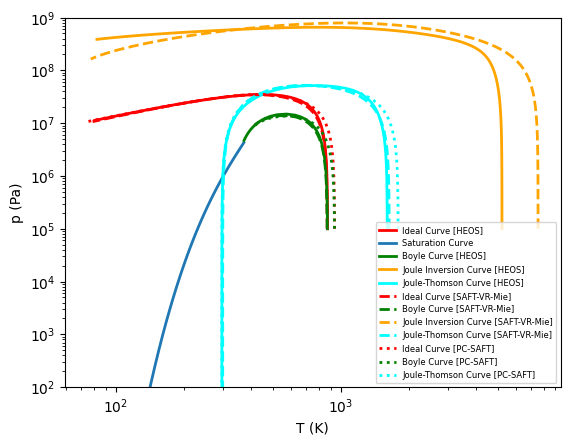

In [3]:
# And here is a block of code that actually does the calculations with the tracer,
# with three different models for propane

backend = 'HEOS'
fluid = 'Propane'
ASCP = CP.AbstractState(backend, fluid)

ASteqpSAFTVRMie = teqpAbstractStateShim({'kind': 'SAFT-VR-Mie', 'model': {'names': [fluid]} })
ASteqpPCSAFT = teqpAbstractStateShim({'kind': 'PCSAFT', 'model': {'names': [fluid]} })

for AS,modelabbrv in [
    (ASCP,'HEOS'),
    (ASteqpSAFTVRMie,'SAFT-VR-Mie'),
    (ASteqpPCSAFT,'PC-SAFT')
    ]:
    print(f'---- {modelabbrv} ----')

    kwargs = dict(lw = 2)
    for klass, label, p0, T0, color in [
        (IdealCurveTracer, 'Ideal Curve', 1e5, 900, 'r'),
        (BoyleCurveTracer, 'Boyle Curve', 1e5, 800, 'g'),
        (JouleInversionCurveTracer, 'Joule Inversion Curve', 1e5, 1800, 'orange'),
        (JouleThomsonCurveTracer, 'Joule-Thomson Curve', 1e5, 1800, 'cyan')
    ]:
        try:
            print(label)
            tracer = klass(AS=AS, p0=p0, T0=T0)
            x,y = tracer.trace()
            if modelabbrv == 'HEOS':
                style = '-'
            elif modelabbrv == 'PC-SAFT':
                style = ':'
            else:
                style = '--'
            plt.plot(x, y, style, label=f'{label} [{modelabbrv}]', color=color, **kwargs)

            if modelabbrv == 'HEOS' and label == 'Ideal Curve':
                print('Saturation Curve')
                Tt = tracer.AS.keyed_output(CoolProp.iT_triple)
                Tc = tracer.AS.keyed_output(CoolProp.iT_critical)
                Ts = np.linspace(Tt, Tc - 1.e-6)
                ps = CoolProp.CoolProp.PropsSI('P','T',Ts,'Q',0,backend + '::' + fluid)
                plt.plot(Ts, ps, '-', label = 'Saturation Curve', **kwargs)
            
        except BaseException as BE:
            print(BE)
            pass         

plt.yscale('log')
plt.xscale('log')
plt.xlabel('T (K)')
plt.ylabel('p (Pa)')
plt.ylim(100, 1e9)
plt.legend(loc='best', fontsize=6)
plt.savefig('ideal_curves.pdf')
plt.show()